**Importing the needed Dependencies**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

**Loading the csv data into a pandas dataframe**

In [ ]:
df = pd.read_csv("/content/traffic (1).csv")
df["DateTime"] = pd.to_datetime(df["DateTime"])

In [ ]:
# Feature engineering
df["Hour"] = df["DateTime"].dt.hour
df["DayOfWeek"] = df["DateTime"].dt.dayofweek
df["IsRushHour"] = df["Hour"].isin([7, 8, 9, 16, 17, 18]).astype(int)
df["Vehicles_Lag1"] = df.groupby("Junction")["Vehicles"].shift(1)
df["Vehicles_MovingAvg"] = df.groupby("Junction")["Vehicles"].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

In [ ]:
# Dropping NaNs
df = df.dropna()

In [ ]:
# Features and target
X = df[["Junction", "Hour", "DayOfWeek", "IsRushHour", "Vehicles_Lag1", "Vehicles_MovingAvg"]]
y = df["Vehicles"]

In [ ]:
# Train-test split (80-20, preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
# Initialize and train model
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, random_state=42)

In [ ]:
# Train
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-rmse:16.01581
[1]	validation_0-rmse:15.86574
[2]	validation_0-rmse:15.71728
[3]	validation_0-rmse:15.57057
[4]	validation_0-rmse:15.42519
[5]	validation_0-rmse:15.28131
[6]	validation_0-rmse:15.13915
[7]	validation_0-rmse:14.99830
[8]	validation_0-rmse:14.85894
[9]	validation_0-rmse:14.72116
[10]	validation_0-rmse:14.58488
[11]	validation_0-rmse:14.44978
[12]	validation_0-rmse:14.31615
[13]	validation_0-rmse:14.18412
[14]	validation_0-rmse:14.05306
[15]	validation_0-rmse:13.92400
[16]	validation_0-rmse:13.79624
[17]	validation_0-rmse:13.66928
[18]	validation_0-rmse:13.54438
[19]	validation_0-rmse:13.42041
[20]	validation_0-rmse:13.29764
[21]	validation_0-rmse:13.17655
[22]	validation_0-rmse:13.05625
[23]	validation_0-rmse:12.93777
[24]	validation_0-rmse:12.82062
[25]	validation_0-rmse:12.70421
[26]	validation_0-rmse:12.58958
[27]	validation_0-rmse:12.47613
[28]	validation_0-rmse:12.36372
[29]	validation_0-rmse:12.25249
[30]	validation_0-rmse:12.14281
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict
y_pred = model.predict(X_test)

In [ ]:
# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
# MAPE (handle division by zero)
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-10, y_test))) * 100

In [ ]:
# Custom accuracy (within ±5 vehicles)
tolerance = 5
custom_accuracy = np.mean(np.abs(y_test - y_pred) <= tolerance) * 100

In [ ]:
# Print all metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Custom Accuracy (within {tolerance} vehicles): {custom_accuracy:.2f}%")

RMSE: 2.99
MAE: 1.58
MSE: 8.96
R² Score: 0.9098
MAPE: 15.89%
Custom Accuracy (within 5 vehicles): 96.84%


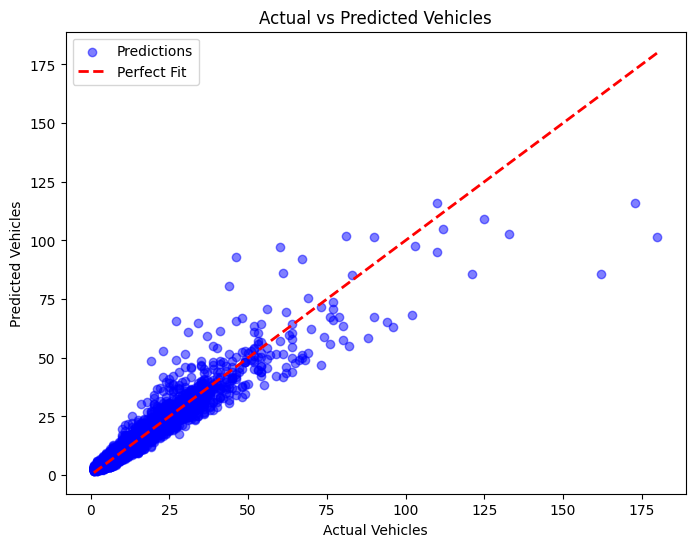

In [ ]:
# 1. Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('Actual vs Predicted Vehicles')
plt.legend()
plt.show()

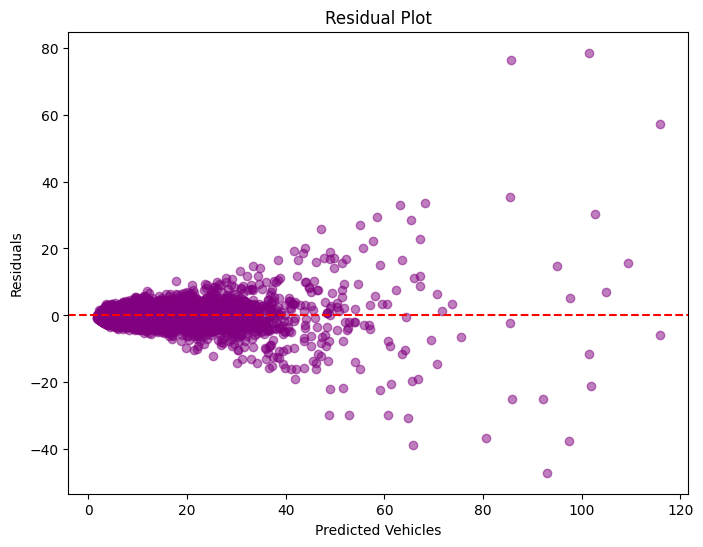

In [ ]:
# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Vehicles')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

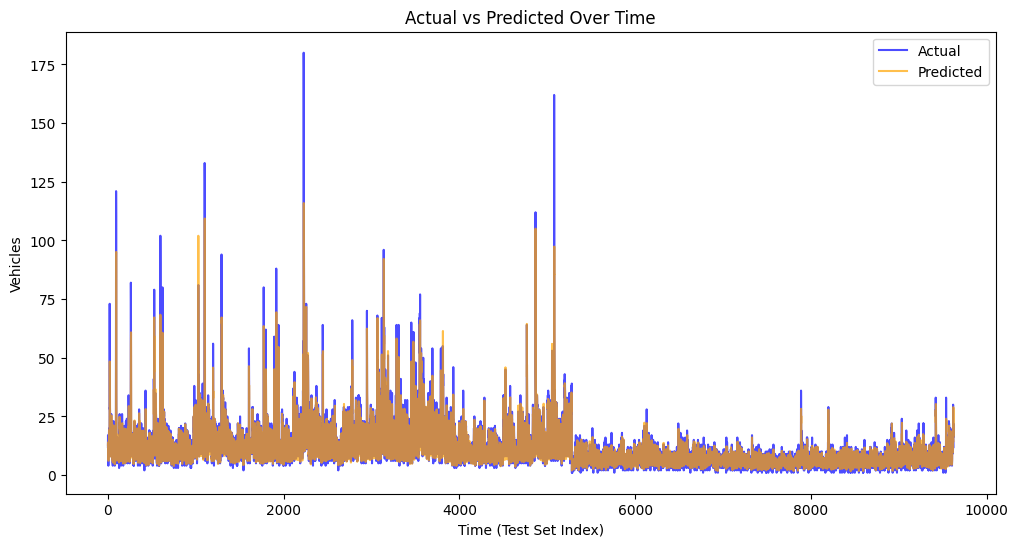

In [ ]:
# 3. Time Series Plot (assuming test data is time-ordered)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted', color='orange', alpha=0.7)
plt.xlabel('Time (Test Set Index)')
plt.ylabel('Vehicles')
plt.title('Actual vs Predicted Over Time')
plt.legend()
plt.show()

<ipython-input-26-6c4c05fd1b7b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=features, palette='viridis')


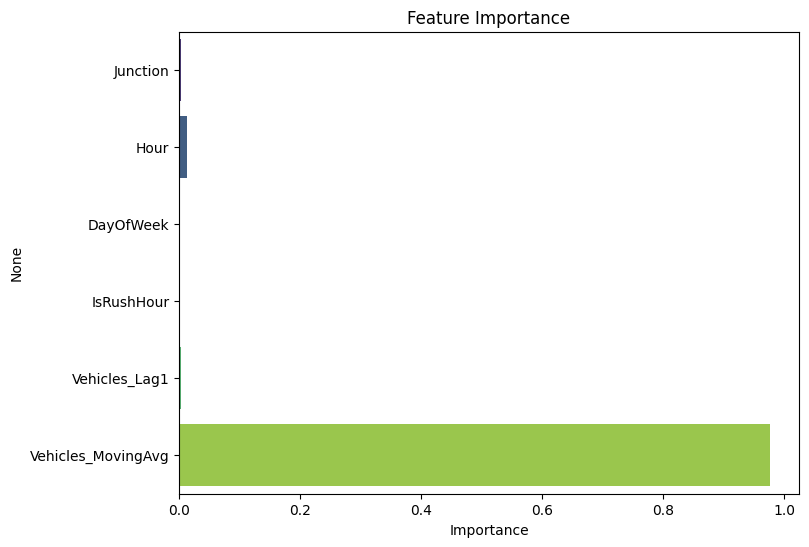

In [ ]:
# 4. Feature Importance Plot
feature_importance = model.feature_importances_
features = X.columns
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=features, palette='viridis')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()